### Short Description

This notebook contains a simple optimization model for a production plan. In the production line we are producing multiple products on one machine over multiple periods. When producing a certain product on the machine a setup must be done, which is costly. Futhermore, The production time of the products differ. The production plan must meet the demand, which is read from an Excel file. The demand must be met in the same period. Further, there are constraints, which will be explained later. \
\
**Goal of this optimization is the minimzation of inventory- and setup costs**

### The algebraic formulation of the model looks the following:

#### Parameters:

\begin{align}
    c^{s} \quad &Setup\ costs\ per\ setup\ process\\
    c^{l} \quad &Inventory\ holding\ costs\ per\ product\ and\ period\\
    a_{p} \quad &Production\ Time\ per\ prodcut\\
    c \quad &Max.\ capacity\\
    demand_{p,t} \quad &Demand\ of\ each\ product\ and\ period\\
\end{align}

#### Decision Variables:

\begin{align}
    X_{p,t} \quad &Production\ quantity\ per\ product\ and\ perid\\
    L_{p,t} \quad &Inventory\ per\ product\ and\ period\\
    \Gamma_{p,t} \quad &Setup\ processes\ per\ product\ and\ period\\
    With\ \Gamma_{p,t} &= 1, if\ there\ is\ a\ setup\ of\ product\ p\ in\ period\ t\ and\ 0\ otherwise\\
\end{align}



#### Objective function:

\begin{align}
    min\sum_{t=1}^{T} \sum_{p=1}^{P} {L}_{p,t} * {c}^{l} + {\Gamma}_{p,t} * {c}^{s}
\end{align}

#### Constraints: 

\begin{align}
    L_{p,t-1} + X_{p,t} - demand_{p,t} &= L_{p,t} & \quad \forall p = 1,...,P \quad \forall t = 1,...,T \\
    X_{p,t} &\leq bigM * \Gamma_{p,t} & \quad \forall p = 1,...,P \quad \forall t = 1,...,T \\
    \Gamma_{p,t} &\in [0;1] & \quad \forall p = 1,...,P \quad \forall t = 1,...,T \\
    \sum_{p=1}^{P} {X}_{p,t} * {a}_{p} &\leq c &\quad \forall p = 1,...,P\\
    L_{p,t}, X_{p,t}&\geq 0 & \quad \forall p = 1,...,P \quad \forall t = 1,...,T \\
\end{align}

### Explaination of the objective function:
The objective function displays the inventory- and setup costs induced. The inventory $L_{p,t}$ quantity get multiplied with a cost factor. Equally, if a setup occurs 1 get multiplied with a cost factor. The inventory costs and the setup costs get mutiplied over all products and periods. The objective is to minimize the costs.

### Explaination of the constraints:
(1) **Inventory balance constraint:** The constraint ensures, that  the development of the inventory remains feasable. The inventory of the last period + the produced quantity - the demand of the periods must equal to the inventory of the current periods. This must hold for all products and periods.

(2) **Setup constraint:** If there is no setup performed $\Gamma_{p,t}$ is 0. With than the right part of the constraint becomes 0. This means the production $X_{p,t}$ quantity can't exceed 0. If $\Gamma_{p,t}$ equals to 1, products can be produced. This must hold for all products and periods.

(3) **Binary constraint of $\Gamma_{p,t}$:** Since $\Gamma_{p,t}$ is a binary variable is can only take values of 0 and 1 This must hold for all products and periods.

(4) **Capacity constraint:** When summing up the production quantity multiplied witht the production time per item, the capacity limit must not be exceeded. This must hold for all periods.

(5) **Non-negativity constraint:** We must ensure that the production quantity and the inventory are greater than 0, since logically they can't be negative. This must hold for all products and periods.

In [1]:
# Import statements
import docplex
import pandas as pd
import numpy as np
from docplex.mp.model import Model
import matplotlib.pyplot as plt

In [4]:
# Getting the data from the Excel file
data = pd.read_excel('Input_clsp.xlsx')
data

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46
0,NaN,Products,Setup Costs,Holding Costs,Production Time,NaN,Demand,1.0,2.0,3.0,...,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0
1,NaN,A,10000,4,0.6,NaN,A,556.0,0.0,264.0,...,14.0,106.0,534.0,246.0,120.0,163.0,448.0,431.0,84.0,459.0
2,NaN,B,15000,3,0.8,NaN,B,274.0,199.0,0.0,...,58.0,545.0,453.0,442.0,338.0,131.0,493.0,492.0,458.0,254.0
3,NaN,C,16000,4,1,NaN,C,307.0,22.0,587.0,...,242.0,0.0,196.0,576.0,445.0,380.0,235.0,445.0,0.0,436.0
4,NaN,D,12000,2,1.6,NaN,D,262.0,298.0,213.0,...,0.0,595.0,0.0,461.0,296.0,59.0,237.0,60.0,552.0,0.0
5,NaN,E,20000,1,0.4,NaN,E,224.0,18.0,360.0,...,264.0,366.0,518.0,464.0,579.0,314.0,239.0,0.0,454.0,360.0
6,NaN,F,10000,3,1.2,NaN,F,206.0,41.0,536.0,...,496.0,346.0,414.0,0.0,155.0,600.0,275.0,229.0,368.0,160.0
7,NaN,G,12000,2,1,NaN,G,521.0,0.0,484.0,...,591.0,552.0,479.0,488.0,249.0,342.0,15.0,207.0,282.0,381.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Getting the parameters from the data, using slicing
products = list(data.iloc[1:8,1])
periods = np.arange(1,41)

input_data = data.iloc[1:8,2:5]
input_data.columns = ['Setup Costs', 'Holding Costs', 'Production Time']
input_data.index = products

demand = data.iloc[1:8, 7:47]
demand.columns = periods
demand.index = products

max_capacity = data.iloc[10,2]

L0 = 0
bigM = 1000000

In [7]:
print(f'Periods: {periods}')
print(f'Products: {products}')
print(f'Parameters: {input_data}')
print(f'Demand: {demand}')
print(f'Max. capacity: {max_capacity}')

Periods: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Products: ['A', 'B', 'C', 'D', 'E', 'F', 'G']
Parameters:   Setup Costs Holding Costs Production Time
A       10000             4             0.6
B       15000             3             0.8
C       16000             4               1
D       12000             2             1.6
E       20000             1             0.4
F       10000             3             1.2
G       12000             2               1
Demand:       1      2      3      4      5      6      7      8      9      10  ...  \
A  556.0    0.0  264.0  526.0  114.0  516.0  481.0  143.0  532.0  239.0  ...   
B  274.0  199.0    0.0  448.0  139.0  228.0    0.0   70.0   89.0  572.0  ...   
C  307.0   22.0  587.0  247.0  386.0   79.0  504.0  164.0  291.0   28.0  ...   
D  262.0  298.0  213.0  219.0  108.0  288.0    0.0  239.0    0.0  187.0  ...   
E  224.0   18.0  360.0  331.0  483.0  506.0  387.0

In [8]:
# Creating the model instance
model = Model(name='clsp', log_outout=False)

In [9]:
# Defining the decision variables
X = model.continuous_var_matrix(products, periods, name='production')
L = model.continuous_var_matrix(products, periods, name='inventory')
G = model.binary_var_matrix(products, periods, name='setup')

In [10]:
# Setting the constraints
# inventory balance equation
model.add_constraints((L[p,t-1] + X[p,t] - demand.loc[p,t] == L[p,t]) for t in periods[1:] for p in products) # skip the first entry in the list of periods
model.add_constraints((L0 + X[p,1] - demand.loc[p,1] == L[p,1]) for p in products)

# setups
model.add_constraints((X[p,t] <= bigM * G[p,t]) for t in periods for p in products)

# capacity may not be exceeded
model.add_constraints(model.sum(input_data.loc[p,'Production Time'] * X[p,t] for p in products) <= max_capacity for t in periods)

[docplex.mp.LinearConstraint[](0.600production_A_1+0.800production_B_1+production_C_1+1.600production_D_1+0.400production_E_1+1.200production_F_1+production_G_1,LE,3000),
 docplex.mp.LinearConstraint[](0.600production_A_2+0.800production_B_2+production_C_2+1.600production_D_2+0.400production_E_2+1.200production_F_2+production_G_2,LE,3000),
 docplex.mp.LinearConstraint[](0.600production_A_3+0.800production_B_3+production_C_3+1.600production_D_3+0.400production_E_3+1.200production_F_3+production_G_3,LE,3000),
 docplex.mp.LinearConstraint[](0.600production_A_4+0.800production_B_4+production_C_4+1.600production_D_4+0.400production_E_4+1.200production_F_4+production_G_4,LE,3000),
 docplex.mp.LinearConstraint[](0.600production_A_5+0.800production_B_5+production_C_5+1.600production_D_5+0.400production_E_5+1.200production_F_5+production_G_5,LE,3000),
 docplex.mp.LinearConstraint[](0.600production_A_6+0.800production_B_6+production_C_6+1.600production_D_6+0.400production_E_6+1.200production_F_6

In [11]:
# Defining the objective function
Z = model.sum(input_data.loc[p, 'Holding Costs'] * L[p,t] + input_data.loc[p, 'Setup Costs'] * G[p,t] for t in periods for p in products)
model.minimize(Z)

In [12]:
# Solving the model
model.solve()
print(model.solve_details)

status  = integer optimal, tolerance
time    = 3.04383 s.
problem = MILP
gap     = 0.00978403%



In [13]:
print(f'The objective value of the model is {model.objective_value}')

The objective value of the model is 1059194.4000000032


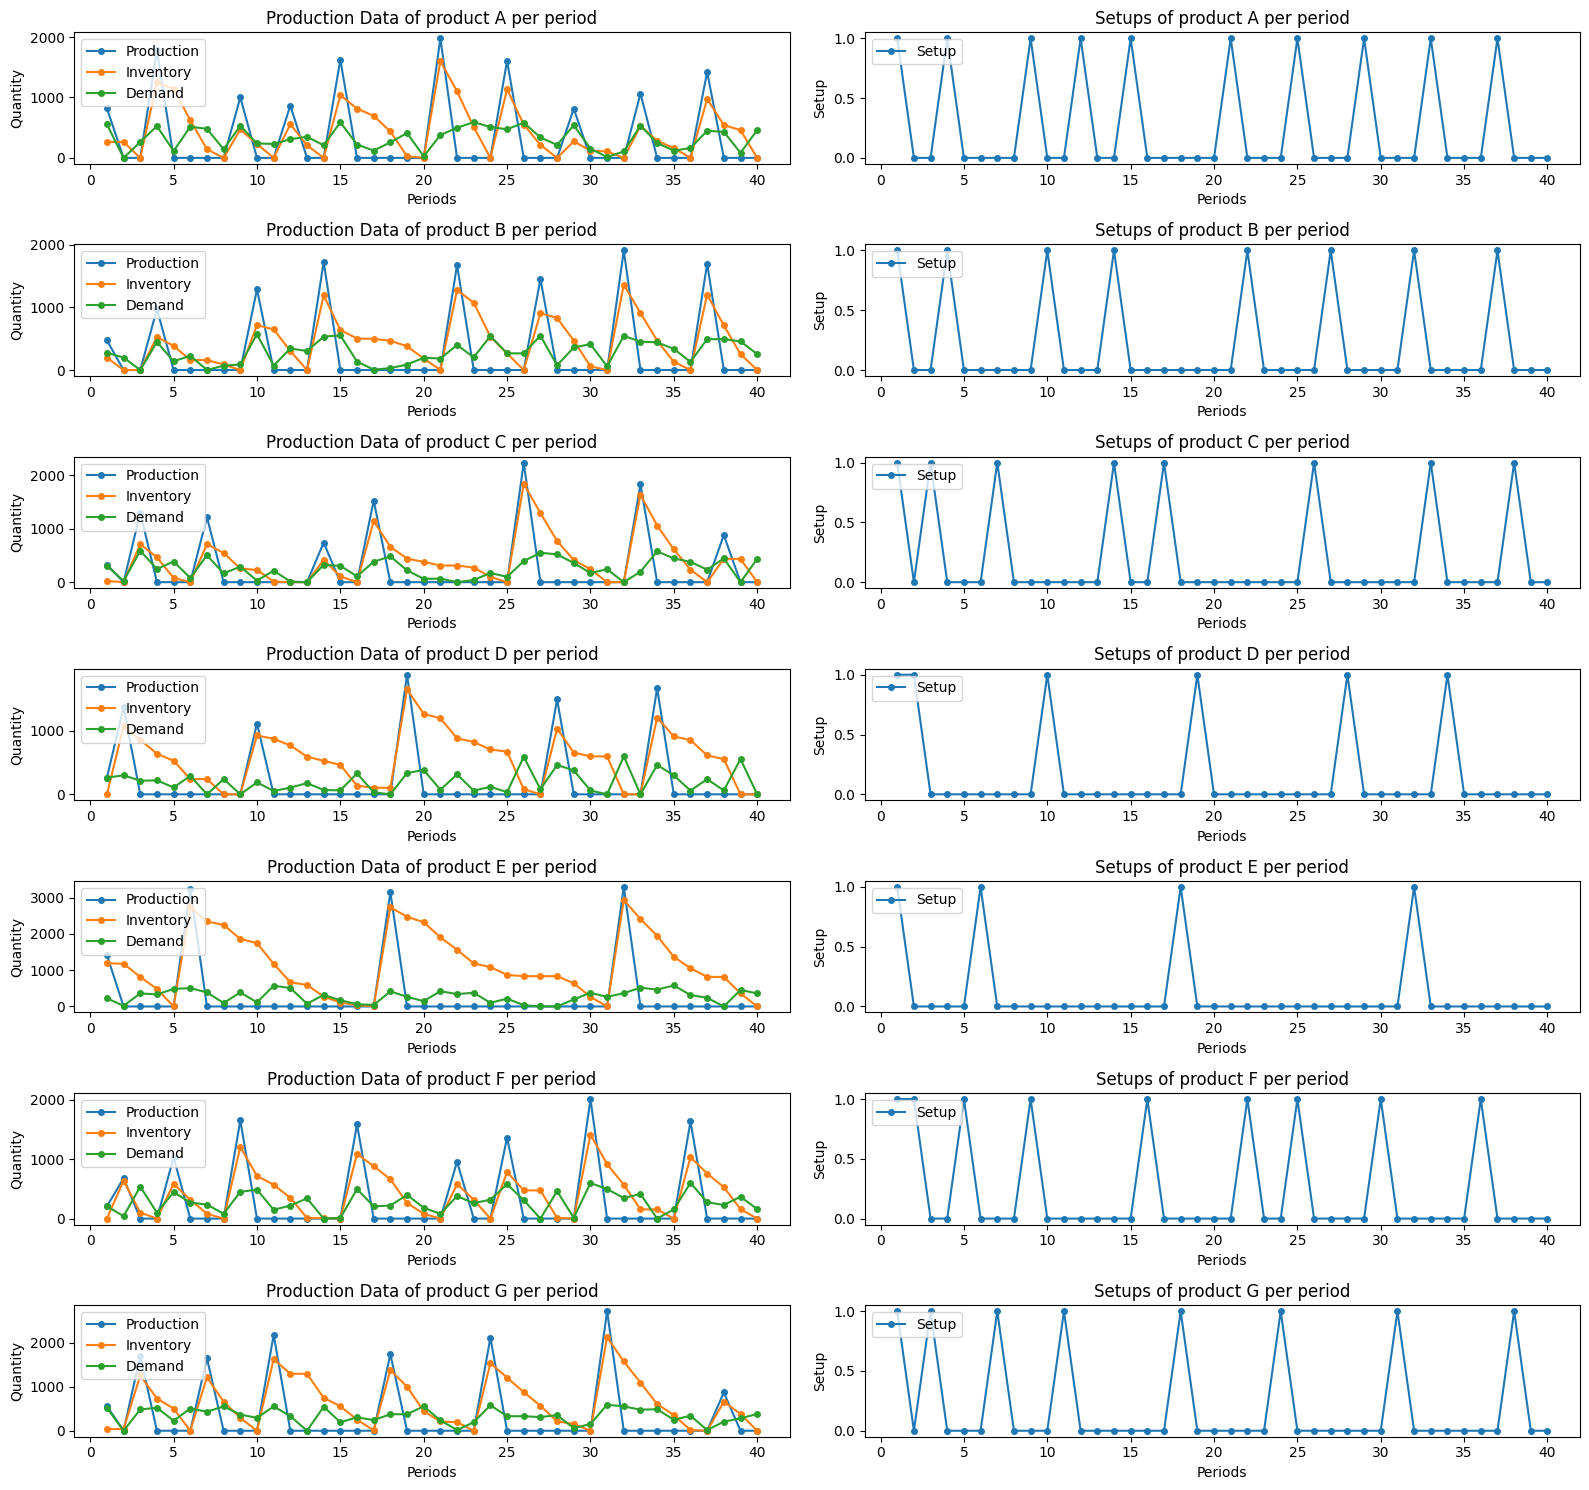

In [14]:
# Plotting the results
fig, ax = plt.subplots(nrows=len(products), ncols=2, figsize=(16,15))
for i in range(len(products)):
    
    ax[i,0].plot(periods, [X[products[i],t].solution_value for t in periods], marker='.', markersize=8, label='Production')
    ax[i,0].plot(periods, [L[products[i],t].solution_value for t in periods], marker='.', markersize=8, label='Inventory')
    ax[i,0].plot(periods, [demand.loc[products[i],t] for t in periods], marker='.', markersize=8, label='Demand')
    ax[i,0].legend(loc='upper left')

    ax[i,1].plot(periods, [G[products[i],t].solution_value for t in periods], marker='.', markersize=8, label='Setup')
    ax[i,1].legend(loc='upper left')

    ax[i,0].set_title(f'Production Data of product {products[i]} per period')
    ax[i,0].set_xlabel('Periods')
    ax[i,0].set_ylabel('Quantity')

    ax[i,1].set_title(f'Setups of product {products[i]} per period')
    ax[i,1].set_xlabel('Periods')
    ax[i,1].set_ylabel('Setup')

plt.tight_layout()

When observing the results, we can see that the model is trying to acchieve the right balance between setups and inventory, since those factors are part of the objective function. For each product we can see spikes of production and a gradual reduction of inventory afterwards to serve the demand. This is logical, since the setup costs are high compared to the inventory costs. Therefore the model is trying the reduce the setups necessary. The graphic also helps us to validate the results. It can be observed, that $\Gamma_{p,t}$ takes a value of 1 of every period with production. Note, that the production quantitiy exceeds the capacity for some periods, since the quantity is not multiplied with the parameter for production time in the graphs.

Text(0, 0.5, 'Utilization in %')

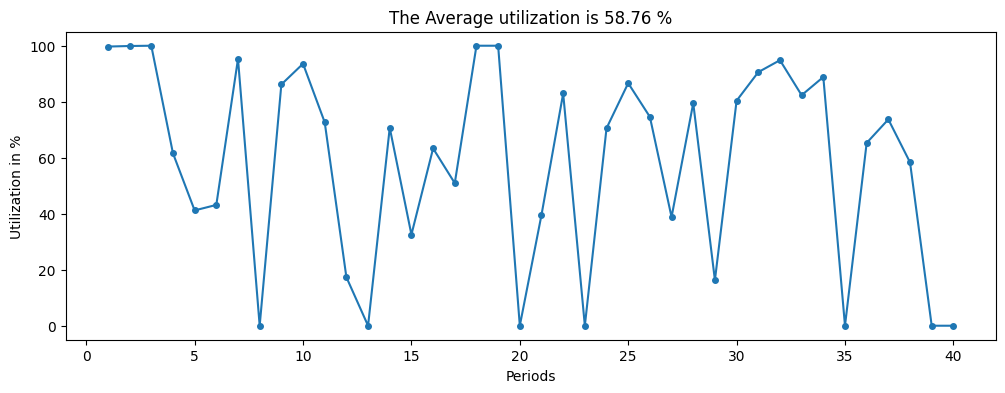

In [15]:
# Plotting the utility of the machine
overall_production = []
for t in periods:
    overall_production.append(np.sum(np.fromiter((X[p,t].solution_value * input_data.loc[p, 'Production Time'] for p in products), int)))

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(periods, [overall_production[i-1] * 100 / max_capacity for i in periods], marker='.', markersize=8, label='Utilization')

ax.set_title(f'The Average utilization is {round(np.average([overall_production[i-1] / max_capacity for i in periods]) * 100, 2)} %')
ax.set_xlabel('Periods')
ax.set_ylabel('Utilization in %')


The graph shows the utilty of the machine for all 40 periods. In some periods a utility of 100% is reached, the average utility is low with 58.76%. This makes sence, since the model proposes spikes of production and low production in the following periods to reduce setup costs.

### Sensitivity Analysis

In a sensitivity analsis we can observe the effect of a changing parameter on the results. This gives us more insights on the implications of the problem. In this case I varied the max. capacity to see, if it makes sence to invest into a bigger machine.

In [56]:
model.clear_constraints()

In [57]:
# inventory balance equation
model.add_constraints((L[p,t-1] + X[p,t] - demand.loc[p,t] == L[p,t]) for t in periods[1:] for p in products) # skip the first entry in the list of periods
model.add_constraints((L0 + X[p,1] - demand.loc[p,1] == L[p,1]) for p in products)

# setups
model.add_constraints((X[p,t] <= bigM * G[p,t]) for t in periods for p in products)

[docplex.mp.LinearConstraint[](production_A_1,LE,1000000setup_A_1),
 docplex.mp.LinearConstraint[](production_B_1,LE,1000000setup_B_1),
 docplex.mp.LinearConstraint[](production_C_1,LE,1000000setup_C_1),
 docplex.mp.LinearConstraint[](production_D_1,LE,1000000setup_D_1),
 docplex.mp.LinearConstraint[](production_E_1,LE,1000000setup_E_1),
 docplex.mp.LinearConstraint[](production_F_1,LE,1000000setup_F_1),
 docplex.mp.LinearConstraint[](production_G_1,LE,1000000setup_G_1),
 docplex.mp.LinearConstraint[](production_A_2,LE,1000000setup_A_2),
 docplex.mp.LinearConstraint[](production_B_2,LE,1000000setup_B_2),
 docplex.mp.LinearConstraint[](production_C_2,LE,1000000setup_C_2),
 docplex.mp.LinearConstraint[](production_D_2,LE,1000000setup_D_2),
 docplex.mp.LinearConstraint[](production_E_2,LE,1000000setup_E_2),
 docplex.mp.LinearConstraint[](production_F_2,LE,1000000setup_F_2),
 docplex.mp.LinearConstraint[](production_G_2,LE,1000000setup_G_2),
 docplex.mp.LinearConstraint[](production_A_3,LE

In [58]:
capacities = np.arange(4500, 2500, -200) # Setting the capacities for the analysis
objective_values = []
utilities = []
inventory_costs = []
setup_costs = []

# Looping over the capacities from highest to lowest capacity
for cap in capacities:
    # Resticting the capacity further with each itteration
    model.add_constraints(model.sum(input_data.loc[p,'Production Time'] * X[p,t] for p in products) <= cap for t in periods)

    # Solving the model
    model.solve()

    # Saving the data we want to observe
    objective_values.append(model.objective_value)
    inventory_costs.append(np.sum(np.fromiter([L[p,t].solution_value * input_data.loc[p, 'Holding Costs'] for p in products for t in periods], int)))
    setup_costs.append(np.sum(np.fromiter([G[p,t].solution_value * input_data.loc[p, 'Setup Costs'] for p in products for t in periods], int)))

    # Calculating the utility
    overall_production = []
    for t in periods:
        overall_production.append(np.sum(np.fromiter((X[p,t].solution_value * input_data.loc[p, 'Production Time'] for p in products), int)))
    utilities.append(overall_production / cap)


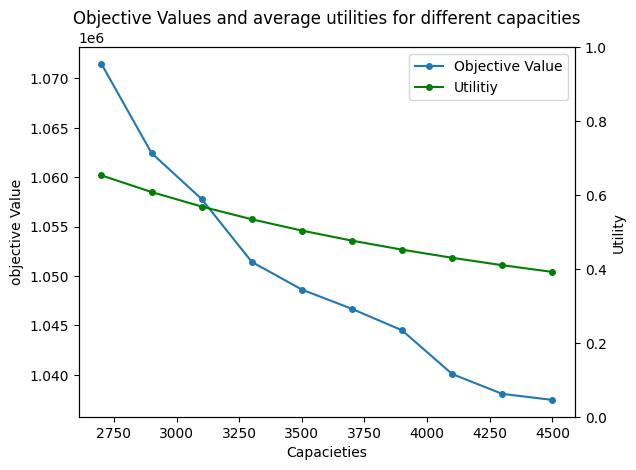

In [59]:
# Plotting the utility
fig, ax = plt.subplots()
ov, = ax.plot(capacities, objective_values, marker='.', markersize=8, label='Objective Value')
ax.set_title('Objective Values and average utilities for different capacities')
ax.set_xlabel('Capacieties')
ax.set_ylabel('objective Value')

ax2 = ax.twinx()
ut, = ax2.plot(capacities, [np.average(util) for util in utilities], marker='.', markersize=8, label='Utilitiy', color='g')
ax2.set_ylim(0,1)
ax2.set_ylabel('Utility')

ax.legend([ov, ut], [ov.get_label(), ut.get_label()])


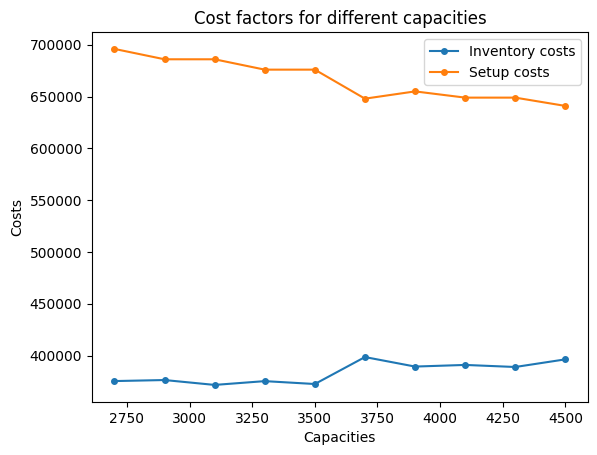

In [62]:
# Plotting the cost factors
fig, ax = plt.subplots()
ax.plot(capacities, inventory_costs, marker='.', markersize=8, label='Inventory costs')
ax.plot(capacities, setup_costs, marker='.', markersize=8, label='Setup costs')
ax.set_title('Cost factors for different capacities')
ax.set_ylabel('Costs')
ax.set_xlabel('Capacities')
plt.legend()

When increasing the capacity, the objective value decreases. This is due to a reduction of setups and a corresponding reduction in setup costs. The inventory costs increase only moderately, due to the lower costs factors. On the other hand the utilty reduces even further to below 40%.

### Stochastic Demand

In [77]:
random = np.random

cv = 0.9
num_scenarios = 5
scenarios = np.arange(1,num_scenarios+1)

demand_stoch = np.zeros(shape=(len(products), len(periods), len(scenarios)))

for s in range(len(scenarios)):
    for p in range(len(products)):
        for t in range(len(periods)):
            if demand.iloc[p,t] == 0:
                continue
            val = random.randint(demand.iloc[p,t] - demand.iloc[p,t] * (1 - cv), demand.iloc[p,t] + demand.iloc[p,t] * (1 - cv))
            if val <= 0:
                demand_stoch[p,t,s] = 0
            else:
                demand_stoch[p,t,s] = val


In [78]:
model_stoch = Model(name='clsp_stoch', log_outout=False)

In [79]:
model_stoch.clear()
X_stoch = model_stoch.continuous_var_cube(products, periods, scenarios, name='production')
L_stoch = model_stoch.continuous_var_cube(products, periods, scenarios, name='inventory')
G_stoch = model_stoch.binary_var_matrix(products, periods, name='setup')
Zs_stoch = model_stoch.continuous_var_dict(scenarios, name='Objective values')

In [80]:
model_stoch.clear_constraints()

# Inventory Balance Equiation
for s in scenarios:
    for p in range(len(products)):
        for t in periods[1:]:
            model_stoch.add_constraint(L_stoch[products[p],t-1,s] + X_stoch[products[p],t,s] - demand_stoch[p,t-1,s-1] == L_stoch[products[p],t,s])
model_stoch.add_constraints(L0 + X_stoch[products[p],1,s] - demand_stoch[p,0,s-1] == L_stoch[products[p],1,s] for p in range(len(products)) for s in scenarios)

# setups
model_stoch.add_constraints((X_stoch[p,t,s] <= bigM * G_stoch[p,t]) for t in periods for p in products for s in scenarios)

# capacity may not be exceeded
model_stoch.add_constraints(model_stoch.sum(input_data.loc[p,'Production Time'] * X_stoch[p,t,s] for p in products) <= max_capacity for t in periods for s in scenarios)

# Objective Function
model_stoch.add_constraints(Zs_stoch[s] == model_stoch.sum(input_data.loc[p, 'Holding Costs'] * L_stoch[p,t,s] + input_data.loc[p, 'Setup Costs'] * G_stoch[p,t] for t in periods for p in products) for s in scenarios)

[docplex.mp.LinearConstraint[](Objective values_1,EQ,4inventory_A_1_1+4inventory_A_2_1+4inventory_A_3_1+4inventory_A_4_1+4inventory_A_5_1+4inventory_A_6_1+4inventory_A_7_1+4inventory_A_8_1+4inventory_A_9_1+4inventory_A_10_1+4inventory_A_11_1+4inventory_A_12_1+4inventory_A_13_1+4inventory_A_14_1+4inventory_A_15_1+4inventory_A_16_1+4inventory_A_17_1+4inventory_A_18_1+4inventory_A_19_1+4inventory_A_20_1+4inventory_A_21_1+4inventory_A_22_1+4inventory_A_23_1+4inventory_A_24_1+4inventory_A_25_1+4inventory_A_26_1+4inventory_A_27_1+4inventory_A_28_1+4inventory_A_29_1+4inventory_A_30_1+4inventory_A_31_1+4inventory_A_32_1+4inventory_A_33_1+4inventory_A_34_1+4inventory_A_35_1+4inventory_A_36_1+4inventory_A_37_1+4inventory_A_38_1+4inventory_A_39_1+4inventory_A_40_1+3inventory_B_1_1+3inventory_B_2_1+3inventory_B_3_1+3inventory_B_4_1+3inventory_B_5_1+3inventory_B_6_1+3inventory_B_7_1+3inventory_B_8_1+3inventory_B_9_1+3inventory_B_10_1+3inventory_B_11_1+3inventory_B_12_1+3inventory_B_13_1+3inventory_

In [81]:
ZZ = model_stoch.sum((1 / num_scenarios) * Zs_stoch[s] for s in scenarios)
model_stoch.minimize(ZZ)

In [82]:
model_stoch.set_time_limit(6000)
model_stoch.solve()
model_stoch.solve_details

docplex.mp.SolveDetails(time=39.6917,status='integer optimal, tolerance')

In [83]:
model_stoch.objective_value

1058231.5599999968

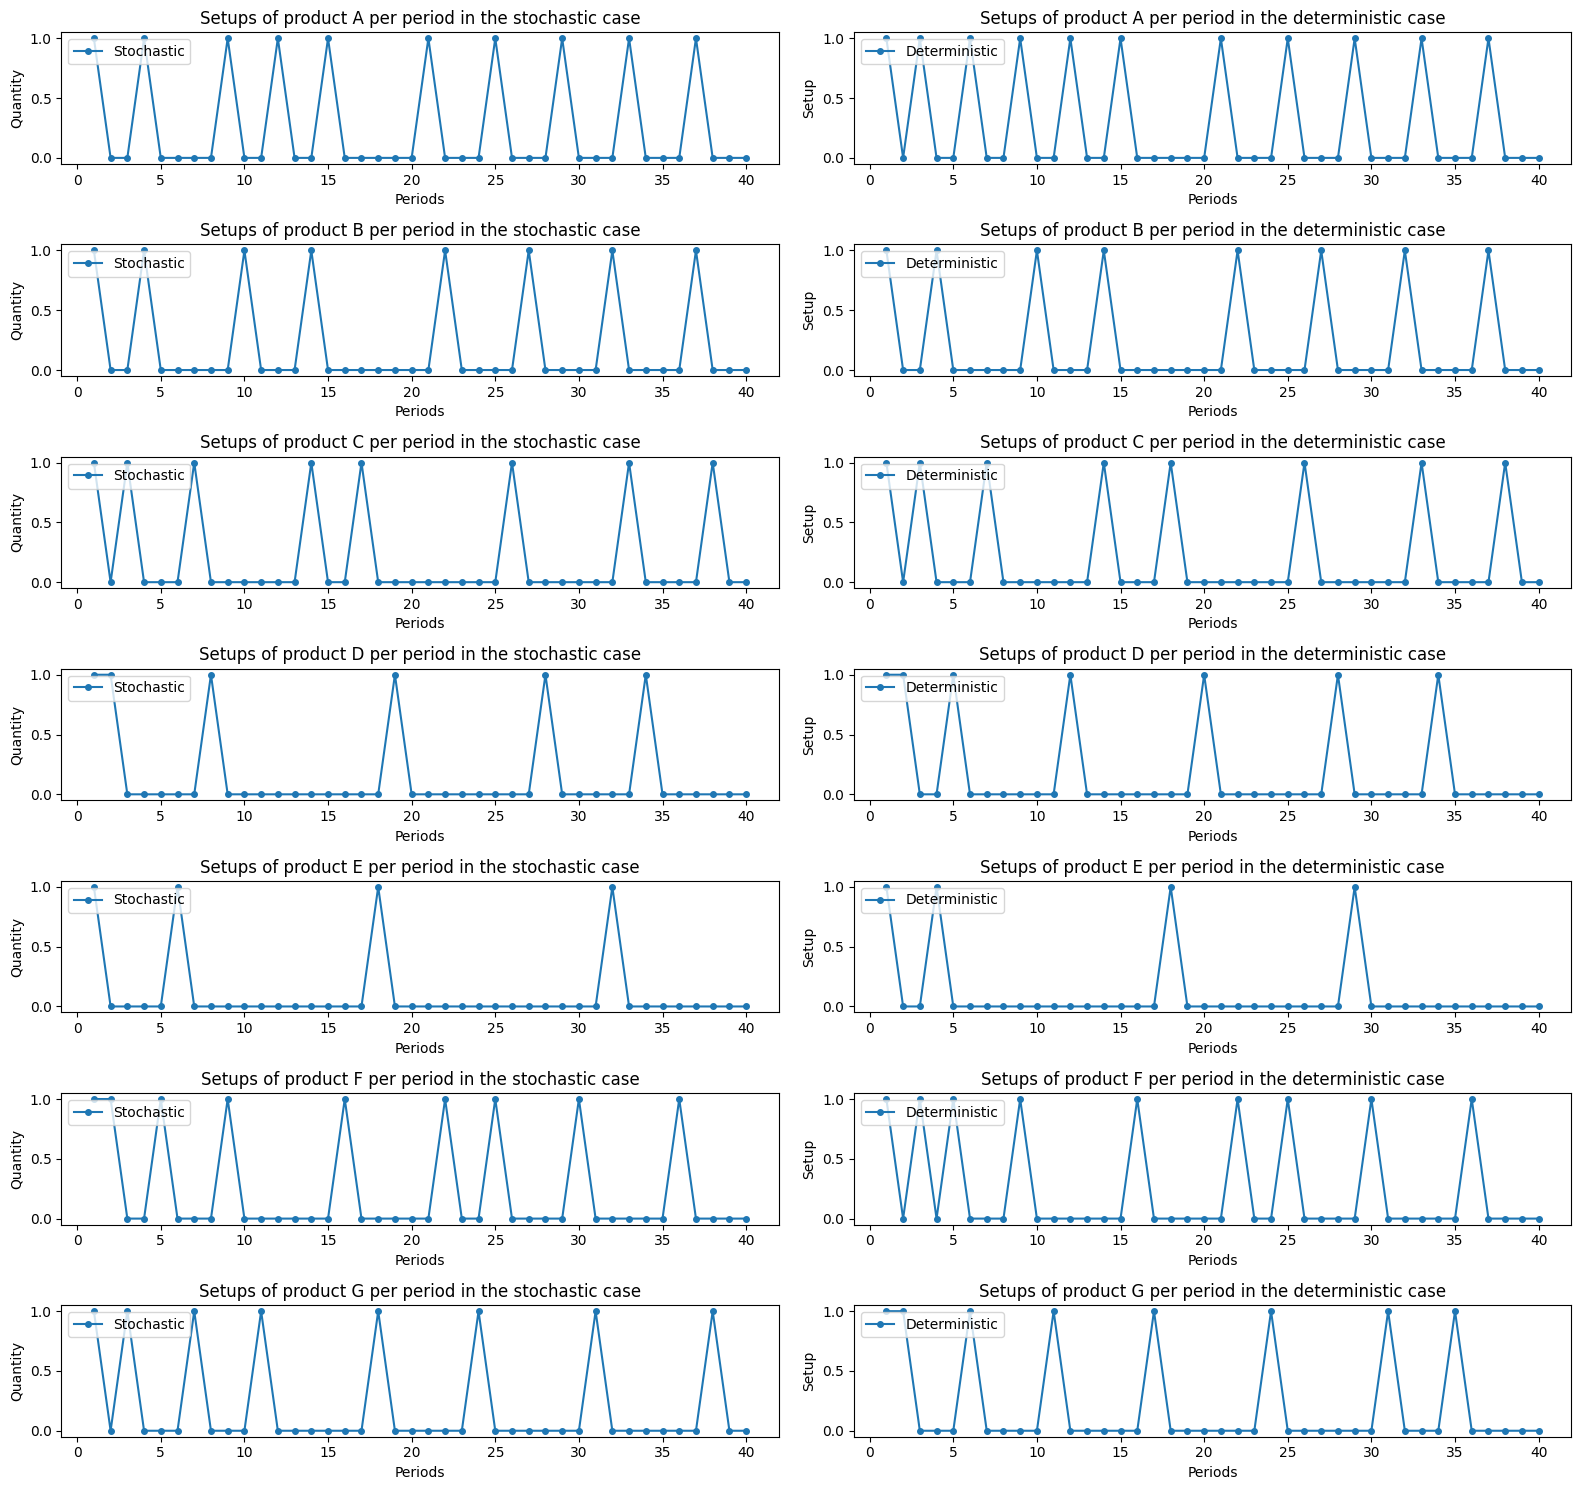

In [84]:
fig, ax = plt.subplots(nrows=len(products), ncols=2, figsize=(16,15))
for i in range(len(products)):
    
    ax[i,0].plot(periods, [G_stoch[products[i],t].solution_value for t in periods], marker='.', markersize=8, label='Stochastic')
    ax[i,0].legend(loc='upper left')

    ax[i,1].plot(periods, [G[products[i],t].solution_value for t in periods], marker='.', markersize=8, label='Deterministic')
    ax[i,1].legend(loc='upper left')

    ax[i,0].set_title(f'Setups of product {products[i]} per period in the stochastic case')
    ax[i,0].set_xlabel('Periods')
    ax[i,0].set_ylabel('Quantity')

    ax[i,1].set_title(f'Setups of product {products[i]} per period in the deterministic case')
    ax[i,1].set_xlabel('Periods')
    ax[i,1].set_ylabel('Setup')

plt.tight_layout()